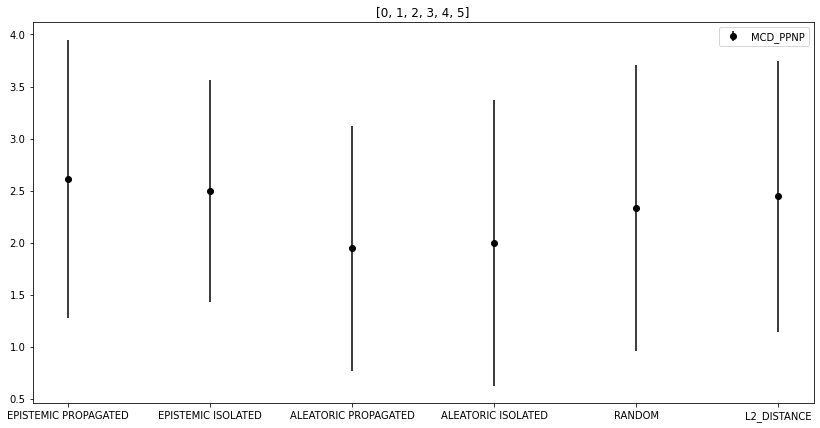

In [6]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

"""
https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
"""

def afterPoint(str):
    return str.split('.')[-1]



tag = "active_learning_cora_h4_v1"
starting_classes = [
        [[0]],
        [[0, 1, 2]],
        [[0, 1, 2, 3, 4, 5]],
        [[0, 1, 2, 3, 4, 5, 6]]
    ]

api = wandb.Api()
runs = api.runs("tum_daml_ba_antoniooroz/GR2", {"tags" : tag})

runs_per_starting_class = {}

for run in runs:
    if run.config['model/type'] != 'ModelType.MCD_PPNP':
        continue
    
    starting_class = str(run.config["experiment/active_learning_starting_class"])
    
    if starting_class in runs_per_starting_class:
        runs_per_starting_class[starting_class].append(run)
    else:
        runs_per_starting_class[starting_class] = [run]
        
for key, runs in runs_per_starting_class.items():
    accuracies = []
    deviations = []
    models = []
    selectors = []
    
    for run in runs:
        accuracy = run.summary["mean/eval/TRAINING/PROPAGATED/datapoints_per_class_6"]
        deviation = run.summary["std/eval/TRAINING/PROPAGATED/datapoints_per_class_6"]
        
        model = afterPoint(run.config["model/type"])
    
        active_learning_selector = afterPoint(run.config["experiment/active_learning_selector"])
        if active_learning_selector == "UNCERTAINTY":
            active_learning_selector = f"{afterPoint(run.config['experiment/active_learning_selector_uncertainty_mode'])} {afterPoint(run.config['experiment/active_learning_selector_network_mode'])}"

        accuracies.append(accuracy)
        deviations.append(deviation)
        models.append(model)
        selectors.append(active_learning_selector)
        
    df = pd.DataFrame(dict(x=selectors, y=accuracies, err=deviations, label=models))
    groups = df.groupby('label')
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.margins(0.05)
    for name, group in groups:
        #ax.set_ylim([0, 1])
        ax.errorbar(group.x, group.y, yerr=group.err, fmt='.k', ms=12, label=name)
        #ax.yaxis.set_ticks(np.arange(0.0, 1.05, 0.05))
    ax.legend(numpoints=1)
    plt.title(key)
    #plt.plot(df.x, df.y, linestyle='', ms=12, label=key)
    plt.show()
